# PME3481 - Controle e Aplicações

## Observador de Estados

### Configuração do Ambiente e Bibliotecas

Introdução das bibliotecas mais importantes.

In [12]:
# !pip install numpy --quiet
# !pip install matplotlib --quiet
# !pip install control --quiet

In [1]:
import numpy as np
import scipy 
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl

In [2]:
def lqr(A, B, Q, R):
    """
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.

    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

In [3]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0
Vvlin = 2.2

In [4]:
# X = [theta,xp,yp,thetap]
# Xp = [thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df + (1/2)*dar*Cd*L*Df*Vvlin**2), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2) - (1/2)*dar*Cd*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)- (1/2)*dar*Cd*Xpe*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0]])

# u = [T,tau]

B = np.array([[0, 0, 0],
              [1/M, 0, 0],
              [0, -Tlin/M, - (1/2)*dar*Cd*L*Df*2*Vvlin],
              [0, -Tlin*Xcm/Izz, - (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin]]) 

# B = np.array([[0, 0, 0],
#               [1/M, 0, 0],
#               [0, -Tlin/M, 0],
#               [0, -Tlin*Xcm/Izz, 0]])

E = np.array([[0],
              [0],
              [ (- (1/2)*dar*Cd*L*Df*2*Vvlin)/(M*Izz)],
              [(- (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin)/(M*Izz)]])

C = np.array([[ 0, 1, 0, 0],
              [ 0, 0, 1, 0],])

D = np.array([[ 0, 0, 0],
              [ 0, 0, 0]])

cont = ctrl.StateSpace(A, B, C, D)

sys = ctrl.ss(A, B, C, D)
sys

<LinearIOSystem:sys[3]:['u[0]', 'u[1]', 'u[2]']->['y[0]', 'y[1]']>

In [5]:
# Primeiro passo é calcular o L, para isso vou criar um sistema com A transposto e C transposto no lugar do B

p = [-1 ,  -0.5 - 0.24j,  -0.5 + 0.24j ,-2 ]

#p = [-2.5,-2.5, -3,-1]

# Calculate the gain matrix K using pole placement
Kbun = scipy.signal.place_poles(A.T, C.T, p, method='YT')
Kobs = Kbun.gain_matrix

L = Kobs.T
print(L)

[[ 0.07837575 -0.2327481 ]
 [ 1.01660346 -0.08997573]
 [-0.43683567  2.98086078]
 [ 0.01647193 -0.06363041]]


In [7]:
#Pegando o K do meu sistema com LQR

Q = np.diag([1, 10, 1,1])          # don't turn too sharply
R = np.diag([0.1, 150, 1])  

Klqr = lqr(A,B, Q, R)

print(Klqr)

[[ 0.66360849  9.8383445   0.27654167 -0.0514717 ]
 [-0.76344129 -0.02950401  0.07829259 -0.37005085]
 [ 0.79204644 -0.26952991 -0.26998697  0.09010012]]


In [8]:
#Para a simulação do observador, tenho que expandir meu vetor variável de estado, a fim de acrescentar o Erro

Acl = A - np.dot(B, Klqr)

Aobs = A - np.dot(L, C)

Atot = np.block([[Acl, np.dot(B,Klqr)],
                [np.zeros_like(A), Aobs]])
Btot = np.block([[B], [np.zeros_like(B)]])
Ctot = np.eye(Atot.shape[0])
Dtot = np.zeros((Atot.shape[0], Btot.shape[1]))

print("Novo A =",Atot)
print("\n")
print("Novo B =",Btot)
print("\n")
print("Novo C =",Ctot)
print("\n")
print("Novo D =",Dtot)

Novo A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.12117231e-01 -4.20388568e-01 -1.17452399e-02  2.18609906e-03
   2.81846883e-02  4.17852814e-01  1.17452399e-02 -2.18609906e-03]
 [-1.69250067e+01 -4.06193701e-01  6.49231288e-01 -3.58460944e+00
   7.13157179e+00  4.06193701e-01 -6.49231288e-01  3.58460944e+00]
 [-1.21931296e+01 -5.05489864e-01  1.22950177e+00 -5.94593303e+00
   1.21980495e+01  5.05489864e-01 -1.22950177e+00  5.94593303e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.83757459e-02  2.32748104e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.40301920e-01 -1.01913922e+00  8.99757262e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -9.79343488e+00  4.36835665e-01 -2.98086078e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

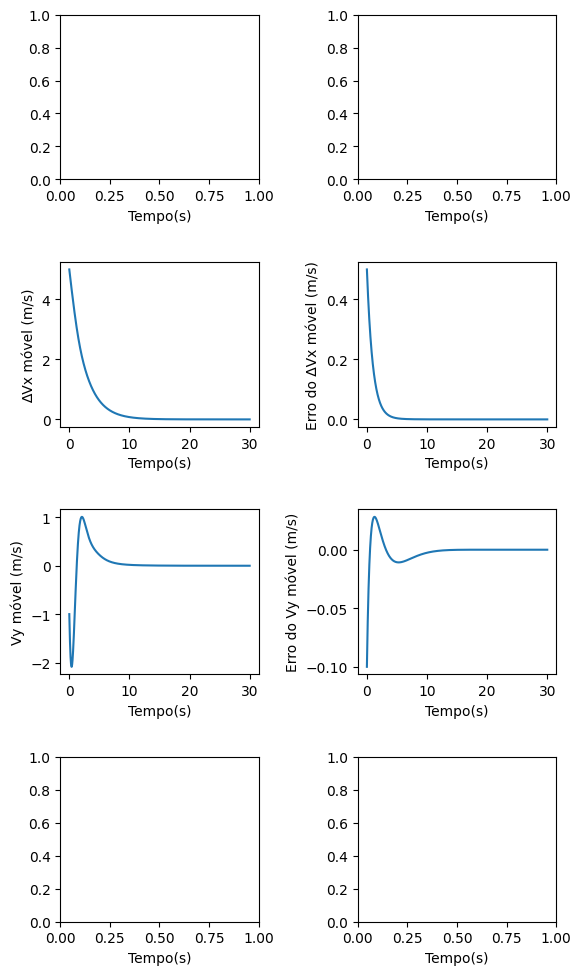

In [13]:
# Com o novo sistema, basta realizar as simulações

sysobs = ctrl.ss(Atot, Btot, Ctot, Dtot)

tempo = np.linspace(0, 30, 400000)
e0 = 10 #em % do valor inicial respectivo
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = [X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0] * e0/100,X0_x[1] * e0/100 ,X0_x[2] * e0/100,X0_x[3] * e0/100]

t, amp,yr = ctrl.forced_response(sysobs, tempo, 0 ,X0 ,return_x = 'True')

f,((ax1, ax2), (ax3,ax4), (ax5, ax6), (ax7,ax8)) = plt.subplots(4, 2)
plt.subplots_adjust(right=0.9, top=2, wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')
ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')

ax3.plot(t, yr[1])
ax3.set_ylabel('∆Vx móvel (m/s)')

ax4.plot(t, yr[5])
ax4.set_ylabel('Erro do ∆Vx móvel (m/s)')

ax5.plot(t, yr[2])
ax5.set_ylabel('Vy móvel (m/s)')

ax6.plot(t, yr[6])
ax6.set_ylabel('Erro do Vy móvel (m/s)')

plt.show(block=False)

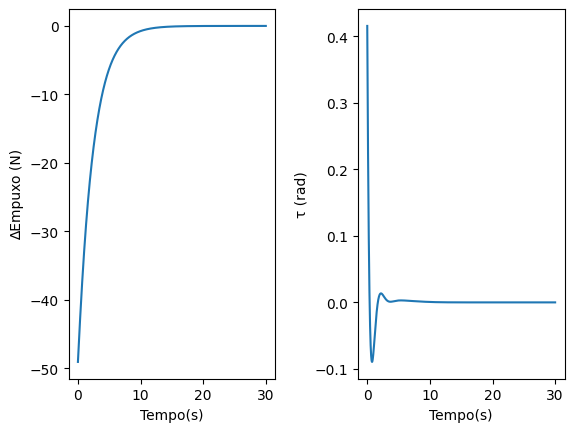

In [11]:
u = np.dot(-Klqr,[yr[0],yr[1],yr[2],yr[3]])
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(right=0.9, wspace=0.4,hspace=0.5)
ax1.plot(t, u[0])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, u[1])
ax2.set_ylabel('τ (rad)')
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)